# Steps
+ Installing dependencies
+ Introduction
+ Pendulum-v0
+ Acrobot-v1
+ CartPole-v1
+ LunarLanderContinuous-v2
+ LunarLander-v2
+ BipedalWalker-v3
+ MountainCarContinuous-v0
+ RoboschoolAnt-v1
+ RoboschoolHalfCheetah-v1

In [1]:
!git clone https://github.com/mandrakedrink/PPO-pytorch
!wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
!pip install roboschool==1.0.48 gym==0.15.4   # roboschool envs (https://github.com/openai/roboschool/issues/210)
!pip install box2d-py   # 2d-boxes envs

# requirements for virtual display
!apt install python-opengl 
!apt install ffmpeg
!apt install xvfb
!pip install pyvirtualdisplay
!pip install xvfbwrapper


from pyvirtualdisplay import Display
import sys

# Add ppo module in system path
sys.path.append("PPO-pytorch/")

# Start virtual display
display = Display(visible=0, size=(600, 400))
display.start()

Cloning into 'PPO-pytorch'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 21 (delta 2), reused 15 (delta 0), pack-reused 0
Unpacking objects: 100% (21/21), done.
Selecting previously unselected package xvfb.
(Reading database ... 144617 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.6_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.6) ...
Setting up xvfb (2:1.19.6-1ubuntu4.6) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
     |████████████████████████████████| 44.9MB 92kB/s 
     |████████████████████████████████| 1.6MB 46.3MB/s 
     |████████████████████████████████| 1.0MB 44.3MB/s 
  Created wheel for gym: filename=gym-0.15.4-cp36-none-any.whl size=1648486 sha256=b4d198d39b31d644f907c3bbfeae117a404d2048bf7abbe9858e10659ab055dc
  Stored in directory: /root/.cache/pip/wheels/e9/26/9b/8a1a6599a91077a938ac4348cc3d3ac84bfab0dbfd

In [17]:
from ppo import PPOAgent

In [2]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt

import gym

from ppo.ppo import PPOAgent
from wrappers import (AcrobotActionWrapper,
                      PendulumActionNormalizer,
                      BipedalWalkerRewardWrapper)
from utils import show_video, convert_gif

In [3]:
class GlobalConfig:
    def __init__(self):
        self.seed = 555
        self.path2save_train_history = "/content/"

def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

config = GlobalConfig()
seed_everything(config.seed)

Proximal Policy Optimization is the one of state of the art reinforcement learning algorithm, its main feature is the control of policy changes, we don't want to deviate too much from the old policy when recalculating weights, this is achieved using surogate loss.

$$
L_{\pi} = \frac{1}{T}\sum_{l=0}^{T-1}
\frac{\pi_\theta(a_{t+l}|s_{t+l})}{\pi_\theta^{\text{old}}(a_{t+l}|s_{t+l})}
A^{\mathrm{GAE}(\gamma,\lambda)}_{t+l}\\
L_{\pi}^{\text{clipped}} = \frac{1}{T}\sum_{l=0}^{T-1}\mathrm{clip}\left(
\frac{\pi_\theta(a_{t+l}|s_{t+l})}{\pi_{\theta^{\text{old}}}(a_{t+l}|s_{t+l})}
\cdot A^{\mathrm{GAE(\gamma, \lambda)}}_{t+l},
1 - \text{cliprange}, 1 + \text{cliprange}\right)\\
L_{\text{policy}} = -\min\left(L_\pi, L_{\pi}^{\text{clipped}}\right).
$$

The PPO uses a generalized advantages estimators for recalculate weights instead advantages as in A2C, it mainly allows to reduce variance

We also use entropy as regularization, basically it allows us to deviate from the "golden policy" and explore other actions, kind of exploration.

More about PPO:
+ https://openai.com/blog/openai-baselines-ppo/
+ https://arxiv.org/abs/1707.06347
+ https://medium.com/@jonathan_hui/rl-proximal-policy-optimization-ppo-explained-77f014ec3f12

More about GAE:
+ https://arxiv.org/abs/1506.02438 - good explanation
+ https://medium.com/@jonathan_hui/rl-policy-gradients-explained-advanced-topic-20c2b81a9a8b

More about entropy as regularization:
+ https://towardsdatascience.com/entropy-regularization-in-reinforcement-learning-a6fa6d7598df
+ https://medium.com/@awjuliani/maximum-entropy-policies-in-reinforcement-learning-everyday-life-f5a1cc18d32d

## **Wrappers**
In gym environments, we can override methods if we need it, a few examples below:


**Change original observations.**

Example: resize image, data normilize...etc
```

class ObservationWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
    
    def observation(self, obs):
        # modify obs
        return obs
```
**Change original rewards.**

Example: standardize rewards in the range (0,1) ...etc.
```
class RewardWrapper(gym.RewardWrapper):
    def __init__(self, env):
        super().__init__(env)
    
    def reward(self, rew):
        # modify rew
        return rew
```

**Change original actions.**

Example: (change the action range (0, 2) to (-1, 1)...etc
```
class ActionWrapper(gym.ActionWrapper):
    def __init__(self, env):
        super().__init__(env)
    
    def action(self, act):
        # modify act
        return act
```


Each environment has its own parameters that describe the space of actions and observations, as well as its other features.

In [ ]:
env = gym.make("Pendulum-v0")  # initializing environment
# env's parameters
print("Action space:", env.action_space)
print("Action sample:", env.action_space.sample())
print("Observations space:", env.observation_space)
print("Observation sample:", env.observation_space.sample())

# other specific parameters
print(f"Torque range: from {-env.env.max_torque} to {env.env.max_torque}")
print("Max speed:", env.env.max_speed)
print("Reward range:", env.env.reward_range)

Action space: Box(1,)
Action sample: [-0.46249434]
Observations space: Box(3,)
Observation sample: [-0.9273403  0.5035639  5.6257563]
Torque range: from -2.0 to 2.0
Max speed: 8
Reward range: (-inf, inf)


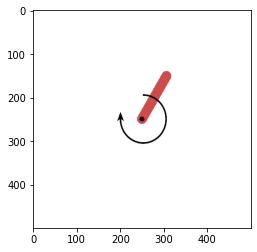

In [ ]:
env.reset() # initial observation
plt.imshow(env.render("rgb_array"));

you can learn more about the environment from its [source code](https://github.com/openai/gym/blob/master/gym/envs/classic_control/pendulum.py) or from a [short description](https://gym.openai.com/envs/Pendulum-v0/) from the openai site.

### Pendulum-v0

In [ ]:
def make_env():
    # environment
    env_id = "Pendulum-v0"
    env = gym.make(env_id)
    env = PendulumActionNormalizer(env)
    env.seed(config.seed)
    return env

In [ ]:
agent = PPOAgent(
    make_env,
    obs_dim = 3,
    act_dim = 1,
    gamma = 0.9,
    lamda = 0.95,
    entropy_coef = 0.005,
    epsilon = 0.2,
    value_range = 0.5,
    rollout_len = 4000,
    total_rollouts = 300,
    num_epochs = 30,
    batch_size = 128,
    is_evaluate = False,
    solved_reward = 0,
    continuous = True,
    plot_interval = 10,
    path2save_train_history = config.path2save_train_history,
)

device: cpu


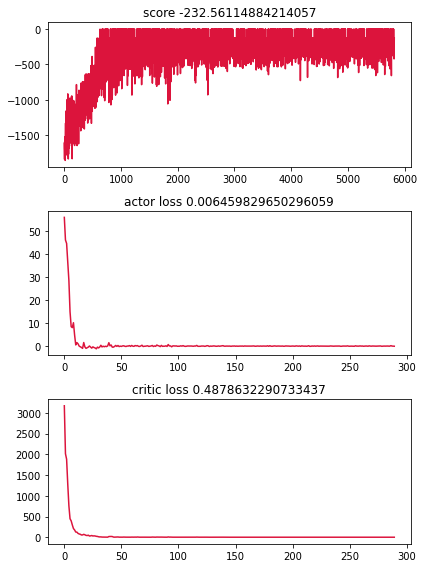

CPU times: user 23min 48s, sys: 6.17 s, total: 23min 55s
Wall time: 23min 52s


In [ ]:
%%time
agent.train()

if kernel dead you can load predtrain weights

In [ ]:
agent.load_predtrain_model("actor.pth", 
                           "critic.pth")

wrapper Monitor create video from image on each t-step in environment

In [ ]:
agent.env = gym.wrappers.Monitor(agent.env, "Pendulum-v0/videos", force=True)
agent.evaluate()

In [ ]:
show_video("/content/Pendulum-v0")

In [ ]:
convert_gif(path="/content/Pendulum-v0/videos/",
            gif_name="gif_name.gif",
            frame_limit=100)

total frames: 101


### Acrobot-v1

In [ ]:
def make_env():
    # environment
    env_id = "Acrobot-v1"
    env = gym.make(env_id)
    env = AcrobotActionWrapper(env)
    env.seed(config.seed)
    return env

In [ ]:
agent = PPOAgent(
    make_env,
    obs_dim = 6,
    act_dim = 3,
    gamma = 0.99,
    lamda = 0.95,
    entropy_coef = 0.003,
    epsilon = 0.12,
    value_range = 0.5,
    rollout_len = 64,
    total_rollouts = 4000,
    num_epochs = 12,
    batch_size = 32,
    is_evaluate = False,
    continuous = False,
    solved_reward = -80,
    path2save_train_history = config.path2save_train_history,
)

device: cpu


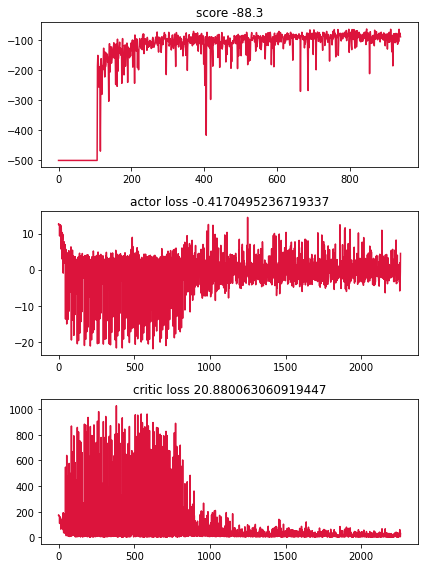

Congratulations, it's solved!
CPU times: user 5min 23s, sys: 23.6 s, total: 5min 47s
Wall time: 5min 22s


In [ ]:
%%time
agent.train()

In [ ]:
agent.env = gym.wrappers.Monitor(agent.env, "Acrobot-v1/videos", force=True)
agent.evaluate()

In [ ]:
show_video("/content/Acrobot-v1/videos")

In [ ]:
convert_gif("/content/Acrobot-v1/videos")

total frames: 89


### CartPole-v1

In [ ]:
def make_env():
    # environment
    env_id = "CartPole-v1"
    env = gym.make(env_id)
    env.seed(config.seed)
    return env 

In [ ]:
agent = PPOAgent(
    make_env,
    obs_dim = 4,
    act_dim = 2,
    gamma = 0.99,
    lamda = 0.95,
    entropy_coef = 0.05,
    epsilon = 0.2,
    value_range = 0.5,
    rollout_len = 500,
    total_rollouts = 5000,
    num_epochs = 12,
    batch_size = 50,
    is_evaluate = False,
    continuous = False,
    solved_reward = 480,
    path2save_train_history = config.path2save_train_history,
)

device: cpu


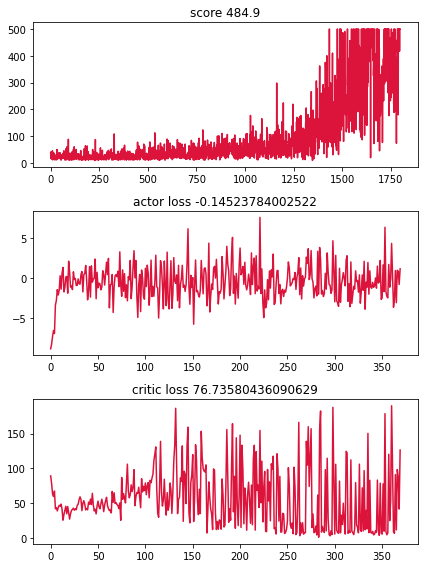

Congratulations, it's solved!
CPU times: user 3min 12s, sys: 4.64 s, total: 3min 17s
Wall time: 3min 13s


In [ ]:
%%time
agent.train()

In [ ]:
agent.env = gym.wrappers.Monitor(agent.env, "CartPole-v1/videos", force=True)
agent.evaluate()

In [ ]:
show_video("/content/CartPole-v1/videos")

In [ ]:
convert_gif("/content/CartPole-v1/videos")

total frames: 101


### LunarLanderContinuous-v2

In [ ]:
def make_env():
    # environment
    env_id = "LunarLanderContinuous-v2"
    env = gym.make(env_id)
    env.seed(config.seed)
    return env 

In [ ]:
agent = PPOAgent(
    make_env,
    obs_dim = 8,
    act_dim = 2,
    gamma = 0.99,
    lamda = 0.95,
    entropy_coef = 0.02,
    epsilon = 0.2,
    value_range = 0.5,
    rollout_len = 320,
    total_rollouts = 2000,
    num_epochs = 8,
    batch_size = 32,
    is_evaluate = False,
    continuous = True,
    solved_reward = 200+30,
    path2save_train_history = config.path2save_train_history,
)

device: cpu


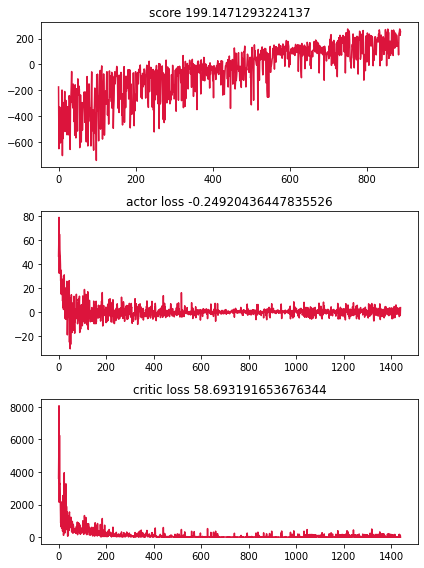

Congratulations, it's solved!
CPU times: user 24min 56s, sys: 14.8 s, total: 25min 11s
Wall time: 24min 56s


In [ ]:
%%time
agent.train()

In [ ]:
agent.env =  gym.wrappers.Monitor(agent.env, "LunarLanderContinuous-v2/videos", force=True)
agent.evaluate()

In [ ]:
show_video("/content/LunarLanderContinuous-v2/videos")

In [ ]:
convert_gif("/content/LunarLanderContinuous-v2/videos")

total frames: 101


### LunarLander-v2

In [ ]:
def make_env():
    # environment
    env_id = "LunarLander-v2"
    env = gym.make(env_id)
    env.seed(config.seed)
    return env 

In [ ]:
agent = PPOAgent(
    make_env,
    obs_dim = 8,
    act_dim = 4,
    gamma = 0.99,
    lamda = 0.95,
    entropy_coef = 0.03,
    epsilon = 0.2,
    value_range = 0.5,
    rollout_len = 240,
    total_rollouts = 20000,
    num_epochs = 8,
    batch_size = 24,
    is_evaluate = False,
    continuous = False,
    solved_reward = 200+30,
    actor_lr = 1e-3,
    critic_lr = 5e-3,
    path2save_train_history = config.path2save_train_history,
)

device: cpu


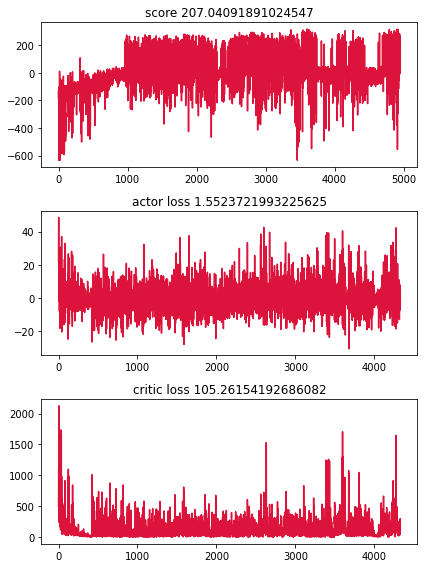

Congratulations, it's solved!
CPU times: user 35min 21s, sys: 48.8 s, total: 36min 10s
Wall time: 35min 23s


In [ ]:
%%time
agent.train()

In [ ]:
agent.env =  gym.wrappers.Monitor(agent.env, "LunarLander-v2/videos", force=True)
agent.evaluate()

In [ ]:
show_video("/content/LunarLander-v2/videos")

In [ ]:
convert_gif("/content/LunarLander-v2/videos")

total frames: 101


### BipedalWalker-v3

In [ ]:
def make_env():
    # environment
    env_id = "BipedalWalker-v3"
    env = gym.make(env_id)
    env = BipedalWalkerRewardWrapper(env)
    env.seed(config.seed)
    return env 

In [ ]:
agent = PPOAgent(
    make_env,
    obs_dim = 24,
    act_dim = 4,
    gamma = 0.99,
    lamda = 0.95,
    entropy_coef = 0.0003,
    epsilon = 0.2,
    value_range = 0.5,
    rollout_len = 8000,
    total_rollouts = 5000,
    num_epochs = 70,
    batch_size = 2000,
    is_evaluate = False,
    continuous = True,
    solved_reward = 250,
    actor_lr = 1e-4,
    critic_lr = 1e-4,
    path2save_train_history = config.path2save_train_history,
)

device: cpu


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


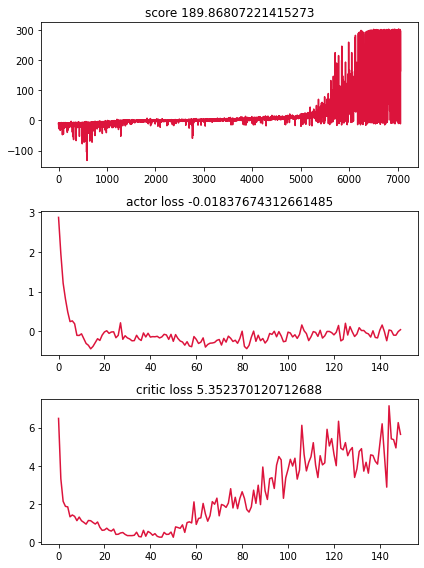

Congratulations, it's solved!
CPU times: user 27min 47s, sys: 7.99 s, total: 27min 55s
Wall time: 27min 55s


In [ ]:
%%time
agent.train()

In [ ]:
agent.env =  gym.wrappers.Monitor(agent.env, "BipedalWalker-v3/videos", force=True)
agent.evaluate()

In [ ]:
show_video("/content/BipedalWalker-v3/videos")

In [ ]:
convert_gif("/content/BipedalWalker-v3/videos")

total frames: 101


### MountainCarContinuous-v0

In [ ]:
def make_env():
    # environment
    env_id = "MountainCarContinuous-v0"
    env = gym.make(env_id)
    env.seed(config.seed)
    return env 

In [ ]:
agent = PPOAgent(
    make_env,
    obs_dim = 2,
    act_dim = 1,
    gamma = 0.99,
    lamda = 0.95,
    entropy_coef = 0.003,
    epsilon = 0.2,
    value_range = 0.5,
    rollout_len = 1000,#
    total_rollouts = 50000,
    num_epochs = 64,
    batch_size = 1000,
    is_evaluate = False,
    continuous = True,
    solved_reward = 92,
    actor_lr = 1e-3,
    critic_lr = 5e-3,
    path2save_train_history = config.path2save_train_history,
)

device: cpu


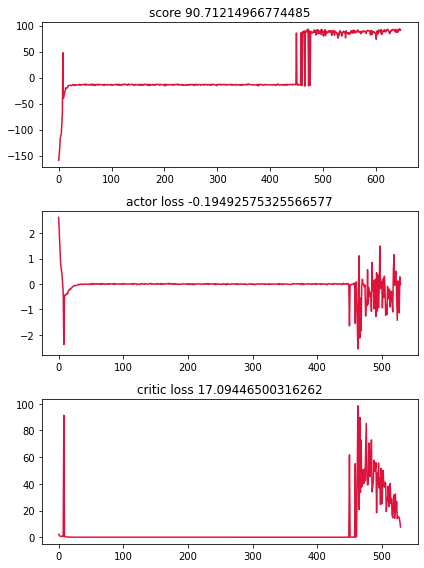

Congratulations, it's solved!
CPU times: user 7min 7s, sys: 5.78 s, total: 7min 13s
Wall time: 7min 7s


In [ ]:
%%time
agent.train()

In [ ]:
agent.env =  gym.wrappers.Monitor(agent.env, "MountainCarContinuous-v0/videos", force=True)
agent.evaluate()

In [ ]:
show_video("/content/MountainCarContinuous-v0/videos")

In [ ]:
convert_gif("/content/MountainCarContinuous-v0/videos")

total frames: 101


### RoboschoolAnt-v1

In [ ]:
import gym
import roboschool

def make_env():
    env = gym.make('RoboschoolAnt-v1')
    #env._max_episode_steps = 1000
    print(env._max_episode_steps )
    return env

In [ ]:
agent = PPOAgent(
    make_env,
    obs_dim = 28,
    act_dim = 8,
    gamma = 0.99,
    lamda = 0.95,
    entropy_coef = 0.0,
    epsilon = 0.2,
    value_range = 0.5,
    rollout_len = 1000,
    total_rollouts = 120000,
    num_epochs = 25,
    batch_size = 100,
    is_evaluate = False,
    continuous = True,
    solved_reward = 1500,
    actor_lr = 1e-4,
    critic_lr = 5e-4,
    path2save_train_history = config.path2save_train_history,
)

device: cpu
1000


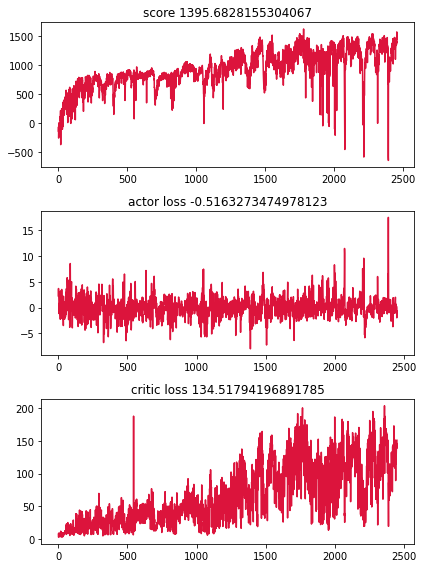

Congratulations, it's solved!
CPU times: user 1h 36min 42s, sys: 30.3 s, total: 1h 37min 12s
Wall time: 1h 36min 44s


In [ ]:
%%time
agent.train()

In [ ]:
agent.env =  gym.wrappers.Monitor(agent.env, "RoboschoolAnt-v1/videos", force=True)
agent.evaluate()

In [ ]:
show_video("/content/RoboschoolAnt-v1/videos")

In [ ]:
convert_gif("/content/RoboschoolAnt-v1/videos")

total frames: 101


### RoboschoolHalfCheetah-v1

In [4]:
import gym
import roboschool

def make_env():
    env = gym.make('RoboschoolHalfCheetah-v1')
    #env._max_episode_steps = 1000
    print(env._max_episode_steps )
    return env

In [5]:
agent = PPOAgent(
    make_env,
    obs_dim = 26,
    act_dim = 6,
    gamma = 0.99,
    lamda = 0.95,
    entropy_coef = 0.0,
    epsilon = 0.2,
    value_range = 0.5,
    rollout_len = 1000,
    total_rollouts = 120000,
    num_epochs = 2,
    batch_size = 5,
    is_evaluate = False,
    continuous = True,
    solved_reward = 1500,
    actor_lr = 1e-4,
    critic_lr = 5e-4,
    path2save_train_history = config.path2save_train_history,
)

device: cpu
1000


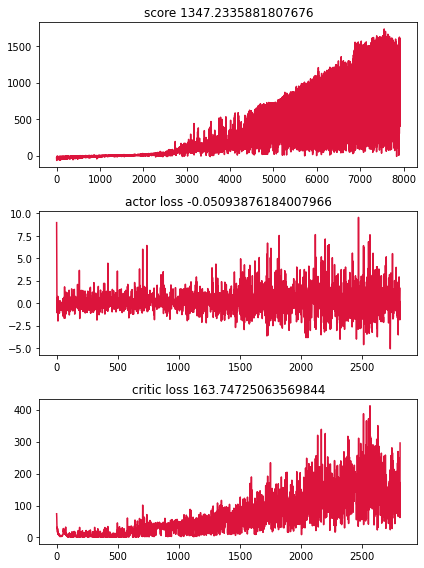

Congratulations, it's solved!
CPU times: user 1h 47min 29s, sys: 31.6 s, total: 1h 48min 1s
Wall time: 1h 47min 33s


In [6]:
%%time
agent.train()

In [7]:
agent.env =  gym.wrappers.Monitor(agent.env, "RoboschoolHalfCheetah-v1/videos", force=True)
agent.evaluate()

In [8]:
show_video("/content/RoboschoolHalfCheetah-v1/videos")

In [12]:
convert_gif("/content/RoboschoolHalfCheetah-v1/videos")

total frames: 101
